In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
author = str.lower(input('Welcome! Who are you? ')[0])

dict_root = {
    'k': '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/DL_Project',
    'z': '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/',
    'r': '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/'
}

if author in dict_root.keys():
  project_root = dict_root[author]
  print('Your root successfully loaded.')
else:
  print('You are not one of us!')
  project_root = '/content'

Welcome! Who are you? k
Your root successfully loaded.


# Packages and Dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import re 
import ast
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
! pip -q install --upgrade --no-cache-dir gdown

In [5]:
import os
import shutil

for fname in ['MSCTD', 'train_ende.zip', 'test.zip']:
  if not fname in os.listdir():
    if not fname in os.listdir(project_root):
      if fname == 'train_ende.zip':
        ! gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
      elif fname == 'test.zip':
        ! gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
      elif fname == 'MSCTD': 
        ! git clone https://github.com/XL2248/MSCTD
    else:
      if fname == 'MSCTD':
        ! git clone https://github.com/XL2248/MSCTD
      else:
        shutil.copy2(os.path.join(project_root, fname), fname)
    if fname in os.listdir():
      if not fname in os.listdir(project_root): 
        if fname == 'MSCTD': 
          shutil.copytree(fname, os.path.join(project_root, fname))
        else: 
          shutil.copy2(fname, os.path.join(project_root, fname))
      print(f'{fname} was added successfully.')
    else:
      print(f'Failed to add {fname}.')

! cp MSCTD/MSCTD_data/ende/english_*.txt .
! cp MSCTD/MSCTD_data/ende/image_index_*.txt .
! cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.
MSCTD was added successfully.
train_ende.zip was added successfully.
test.zip was added successfully.


In [6]:
%%bash
for x in *.zip 
do 
  unzip -qq $x
done;

## MSCTDataset

In [7]:
class MSCTDataset(Dataset):
    def __init__(self, dirs_dict, include_images=True, include_sentences=True, \
                 include_dialogues=True, include_index=False, pack_dialogues=False,\
                 image_transform=None, sentence_transform=None, sentiment_transform=None):
        assert include_images or include_sentences, 'you should indicate at least one domain for the dataset.'
        assert isinstance(dirs_dict, dict)
        assert dirs_dict['sentiment']
        self.sentiment_dir = dirs_dict['sentiment']
        self.sentiments = read_txt(self.sentiment_dir, int)
        self.include_images = include_images
        self.include_sentences = include_sentences
        self.include_dialogues = include_dialogues
        self.include_index = include_index
        self.pack_dialogues = pack_dialogues
        self.image_transform = image_transform
        self.sentence_transform = sentence_transform
        self.sentiment_transform = sentiment_transform

        if include_images:
            assert dirs_dict['image']
            self.image_dir = dirs_dict['image']
        if include_sentences:
            assert dirs_dict['sentence']
            self.sentence_dir = dirs_dict['sentence']
            self.sentences = read_txt(self.sentence_dir)
        if include_dialogues or pack_dialogues:
            assert dirs_dict['dialogue']
            self.dialogue_dir = dirs_dict['dialogue']
            self.dialogues = read_txt(self.dialogue_dir, ast.literal_eval)

    def __len__(self):
        if self.pack_dialogues:
          return len(self.dialogues)
        else:
          return len(self.sentiments)

    def __getoneitem__(self, idx):
        outputs = list()
        if self.include_index:
          outputs.append(idx)
        if self.include_images:
          img_path = os.path.join(self.image_dir, str(idx) + '.jpg')
          image = Image.open(img_path) # read_image(img_path)
          if self.image_transform:
            image = self.image_transform(image)
          outputs.append(image)

        if self.include_sentences:
          sentence = self.sentences[idx]
          if self.sentence_transform:
            sentence = self.sentence_transform(sentence)
          outputs.append(sentence)

        if self.include_dialogues:
          for dialogue in self.dialogues:
            if idx in dialogue:
              break
          outputs.append(dialogue)
        
        sentiment = self.sentiments[idx]
        if self.sentiment_transform:
          sentiment = self.sentiment_transform(sentiment)
        outputs.append(sentiment)
        return outputs

    def __getitem__(self, idx):
      if self.pack_dialogues:
        indices = self.dialogues[idx]
        outputs = [self.__getoneitem__(i) for i in indices]
        final_output = [[outputs[i][j] for i in range(len(outputs))] for j in range(len(outputs[0]))]
        return final_output
      else:
        return self.__getoneitem__(idx)

      
def read_txt(path, line_transform=None):
    ls = list()
    with open(path, 'r') as f:
        for line in f:
            if line_transform:
              line = line_transform(line)
            else:
              if line[-1:] == '\n':
                line = line[:-1]
            ls.append(line)
    return ls

In [8]:
train_dirs = {'image':'/content/train_ende', 'sentence':'/content/english_train.txt', \
              'dialogue':'/content/image_index_train.txt', 'sentiment':'/content/sentiment_train.txt'}
test_dirs = {'image':'/content/test', 'sentence':'/content/english_test.txt', \
              'dialogue':'/content/image_index_test.txt', 'sentiment':'/content/sentiment_test.txt'}

dataset = dict()
dataset['train'] = MSCTDataset(train_dirs, include_images=False, include_dialogues=False)
dataset['test'] = MSCTDataset(test_dirs, include_images=False, include_dialogues=False)

In [9]:
sentence, sentiment = dataset['train'][777]
sentence, sentiment

("I think we've heard everything this gentlemen", 0)

In [10]:
dataframe = pd.DataFrame(columns=['sentence', 'sentiment'])
sentences, sentiments = [], []
for (sentence, sentiment) in dataset['train']:
  sentences.append(sentence)
  sentiments.append(sentiment)
dataframe['sentence'] = sentences
dataframe['sentiment'] = sentiments
dataframe.tail(10)

,sentence,sentiment
20230,"You know what? No, sell 'em! I wanna purge,",1
20231,"Oh, every time. Every time he loses weight,",1
20232,"And then when he puts the weight back on,",0
20233,Where you think you're going with those?,1
20234,"Oh, these aren't for sale.",1
20235,"Hey, this is for charity.",2
20236,You know you're taking those jeans out of the ...,0
20237,"You know they're not getting the actual jeans,...",0
20238,"Oh. Right. Well, then how about a donation?",2
20239,20 bucks?,1


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


# Building Representation Vectors

## TF-IDF Vectors

In [ ]:
class Vectorizer():
    def __init__(self,clean_pattern=None,max_features=None,stop_words=None):
        self.clean_pattern = clean_pattern
        self.max_features = max_features
        self.stopwords = stop_words
        self.tfidf = TfidfVectorizer(stop_words=self.stopwords,max_features=self.max_features)
        self.builded = False
        
    
    def _clean_texts(self,texts):
        
        cleaned = []
        for text in texts:
            if self.clean_pattern is not None:
                text = re.sub(self.clean_pattern," ",text)
            
            text = text.lower().strip()
            cleaned.append(text)
        
        return cleaned
    
    
    def _set_tfidf(self,cleaned_texts):
        self.tfidf.fit(cleaned_texts)
    
    def build_vectorizer(self,texts):
        cleaned_texts = self._clean_texts(texts)
        self._set_tfidf(cleaned_texts)
        self.builded = True
        
    def vectorizeTexts(self,texts):
        if self.builded:
            cleaned_texts = self._clean_texts(texts)
            return self.tfidf.transform(cleaned_texts)
        
        else:
            raise Exception("Vectorizer is not builded.")
            

In [ ]:
x = list(dataframe["sentence"])
y = list(dataframe["sentiment"])

In [ ]:
vectorizer = Vectorizer("[^a-zA-Z0-9]",max_features=7000,stop_words="english");
vectorizer.build_vectorizer(x)
vectorized_x = vectorizer.vectorizeTexts(x).toarray()
y_encoded = np.asarray(y)
vectorized_x.shape, y_encoded.shape

((20240, 7000), (20240,))

In [ ]:
class SentenceDataset(Dataset):
    
    def __init__(self,x_vectorized,y_encoded):
        self.x_vectorized = x_vectorized
        self.y_encoded = y_encoded
        
    
    def __len__(self):
        return len(self.x_vectorized)
    
    
    def __getitem__(self,index):
        return self.x_vectorized[index],self.y_encoded[index]


In [ ]:
dataset = SentenceDataset(vectorized_x,y_encoded)
print("Length of our dataset is",len(dataset))

print(dataset[2])

Length of our dataset is 20240
(array([0., 0., 0., ..., 0., 0., 0.]), 1)


In [ ]:
train_indices, test_indices = train_test_split(list(range(0,len(dataset))),test_size=0.25,random_state=42)

In [ ]:
print(len(train_indices))
print(len(test_indices))

15180
5060


In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=test_sampler)

In [ ]:
class DenseNetwork(nn.Module):
    
    def __init__(self):
        super(DenseNetwork,self).__init__()
        self.fc1 = nn.Linear(7000,1024)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024,256)
        self.drop2 = nn.Dropout(0.4)
        self.prediction = nn.Linear(256,4)
        
    def forward(self,x):
        
        x = F.relu(self.fc1(x.to(torch.float)))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.log_softmax(self.prediction(x),dim=1)
        
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = DenseNetwork().to(device)

cuda:0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 10
TRAIN_LOSSES = []
TRAIN_ACCURACIES = []

for epoch in range(1,EPOCHS+1):
    epoch_loss = 0.0
    epoch_true = 0
    epoch_total = 0
    for data_,target_ in train_loader:
        data_ = data_.to(device)
        target_ = target_.to(device)
        
        # Cleaning optimizer cache.
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss & backward propagation
        loss = criterion(outputs,target_)
        loss.backward()
        
        # Applying gradients
        optimizer.step()
        
        epoch_loss += loss.item()
        
        _,pred = torch.max(outputs,dim=1)
        epoch_true = epoch_true + torch.sum(pred == target_).item()
        
        epoch_total += target_.size(0)
        
    TRAIN_LOSSES.append(epoch_loss)
    TRAIN_ACCURACIES.append(100 * epoch_true / epoch_total)
    
    print(f"Epoch {epoch}/{EPOCHS} finished: train_loss = {epoch_loss}, train_accuracy = {TRAIN_ACCURACIES[epoch-1]}")

Epoch 1/10 finished: train_loss = 86.93238443136215, train_accuracy = 68.66930171277997
Epoch 2/10 finished: train_loss = 75.20267671346664, train_accuracy = 73.15546772068511
Epoch 3/10 finished: train_loss = 65.66411897540092, train_accuracy = 76.64690382081686
Epoch 4/10 finished: train_loss = 56.46597737073898, train_accuracy = 80.00658761528327
Epoch 5/10 finished: train_loss = 48.482492849230766, train_accuracy = 83.39262187088273
Epoch 6/10 finished: train_loss = 41.80658334493637, train_accuracy = 85.37549407114625
Epoch 7/10 finished: train_loss = 37.29965528845787, train_accuracy = 87.167325428195
Epoch 8/10 finished: train_loss = 33.645886942744255, train_accuracy = 88.22134387351778
Epoch 9/10 finished: train_loss = 31.233985543251038, train_accuracy = 88.79446640316206
Epoch 10/10 finished: train_loss = 29.28684864938259, train_accuracy = 89.42028985507247


In [ ]:
PATH = project_root + f"/Phase2/models/dense_network.pkl"
torch.save(
    model.state_dict(), "./models"
)

### Load the trained model

In [ ]:
PATH = project_root + "/Phase2/dense_network.pkl"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
n_true = 0
test_total = len(test_sampler)
test_loss = 0.0
test_pred, test_true = [], []
with torch.no_grad():
    for data_,target_ in test_loader:
        data_,target_ = data_.to(device),target_.to(device)
        
        outputs = model(data_)
        
        loss = criterion(outputs,target_).item()
        
        _,pred = torch.max(outputs,dim=1)
        
        n_true += torch.sum(pred==target_).item()
        test_loss += loss
        test_true.append(target_.cpu().numpy())
        test_pred.append(pred.cpu().numpy())
test_pred = np.concatenate(test_pred)
test_true = np.concatenate(test_true)

print(f"Validation finished: Accuracy = {round(100 * n_true / test_total,2)}%, Loss = {test_loss:.4f}")

Validation finished: Accuracy = 48.12%, Loss = 81.7023


In [ ]:
# REPORT ACCURACY AND F1-SCORE FOR VALIDATION DATA
from sklearn.metrics import classification_report
label_names = ['Upset', 'Neutral', 'Happy']
print('Classifiation report for test set')
print(classification_report(test_pred, test_true,target_names=label_names))

Classifiation report for test set
              precision    recall  f1-score   support

       Upset       0.54      0.45      0.49      2083
     Neutral       0.53      0.52      0.53      1998
       Happy       0.33      0.46      0.39       979

    accuracy                           0.48      5060
   macro avg       0.47      0.48      0.47      5060
weighted avg       0.50      0.48      0.49      5060



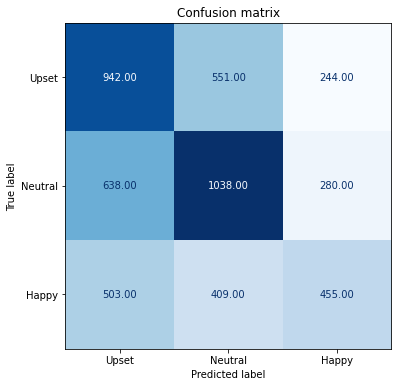

In [ ]:
# CONFUSION MATRIX FOR VALIDATION DATA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Confusion matrix")
  plt.show()

plot_confusion_matrix(test_pred, test_true,labels=label_names)

## Word2Vec

In [ ]:
import random
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [ ]:
dataframe['sentence'] = dataframe['sentence'].str.lower()
dataframe['sentence'] = dataframe['sentence'].str.replace(r'[^\w\s]+', '')
dataframe['sentence']

<ipython-input-26-5a0b4c4c5eae>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['sentence'] = dataframe['sentence'].str.replace(r'[^\w\s]+', '')


0                                         okay im confused
1                 you dont care if i go to paris with jane
2                    im sorry i have to tell you something
3                                             i have to go
4                                im an accessory to murder
                               ...                        
20235                              hey this is for charity
20236    you know youre taking those jeans out of the h...
20237    you know theyre not getting the actual jeans r...
20238              oh right well then how about a donation
20239                                             20 bucks
Name: sentence, Length: 20240, dtype: object

In [ ]:
docs = dataframe['sentence']
vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b',)
X = vectorizer.fit_transform(docs)
V = X.toarray()
V.shape

(20240, 10345)

In [ ]:
def word2idx(word):
  return np.where(vectorizer.get_feature_names_out()==word)[0][0]

We build one SVM classifier for each sentence and devote the mean of support vectors as the representation vector for all words in the sentence. In case a word exists multiple sentences, we consider the mean of calculated representation vectors as the final representation vector.

In [ ]:
svms = dict()
vocabulary = vectorizer.vocabulary_.keys()
for doc in tqdm(docs, desc='Processing documents...'):
  pos_words = doc.split()
  mini_data = [] 

  # ADD THE POSITIVE POINTS TO THE MINI DATASET
  for w in pos_words:
    x = V[:, word2idx(w)]
    label = 1
    mini_data.append((x, label))

  # ADD THE NEGATIVE POINTS TO THE MINI DATASET
  v_list = [v for v in vocabulary if v not in pos_words]
  neg_words = random.choices(v_list, k = len(pos_words))
  for w in neg_words:
    x = V[:, word2idx(w)]
    label = -1
    mini_data.append((x, label))

  df = pd.DataFrame(mini_data, columns=['vector', 'label'])
  x = df.vector.tolist()
  clf = SVC(kernel='linear')
  clf.fit(x, df.label)
  for w in pos_words:
    if w not in svms.keys():
      svms[w] = (1, np.mean(clf.support_vectors_, axis=0))
    elif w in svms.keys():
      count, sum_vector = svms[w] 
      count += 1
      sum_vector += np.mean(clf.support_vectors_, axis=0)
      svms[w] = (count, sum_vector)


Processing documents...: 100%|██████████| 20240/20240 [35:05<00:00,  9.61it/s]


In [ ]:
for k in svms:
  svms[k] = svms[k][1]/svms[k][0]

In [ ]:
dataset = pd.DataFrame(columns=['vector', 'label'])
vectors = []
for doc in docs:
  vector = np.zeros(len(docs))
  for word in doc.split():
    vector += svms[word]
  vector /= len(doc.split())
  vectors.append(vector)

In [ ]:
dataset['vector'] = vectors
dataset['label'] = dataframe['sentiment']
dataset.head(10)

,vector,label
0,"[0.07012956294772517, 0.008525763826939809, 0....",0
1,"[0.001448517748087208, 0.034324061764179854, 0...",0
2,"[0.00837174740988838, 0.012439756255498185, 0....",1
3,"[0.001883048477656562, 0.020513148028113014, 0...",1
4,"[0.015327676843589794, 0.0104980345624417, 0.0...",1
5,"[0.0014475138656266455, 0.01211116006324495, 0...",2
6,"[0.0011477937490122114, 0.010557722169681328, ...",1
7,"[0.0014942602827750168, 0.008565744871680783, ...",1
8,"[0.0024906353776327187, 0.012735793710155652, ...",0
9,"[0.0014176423235365073, 0.011807402967037348, ...",1


In [ ]:
PATH = project_root + r"/Phase2/"
df.to_csv(PATH+'dataframe_SVM.csv')

In [ ]:
x = dataset.vector.to_list()
y = dataset['label']
len(x), len(y)

(20240, 20240)

In [ ]:
x[1].shape

(20240,)

In [ ]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
clf.score(x, y)

In [ ]:
class SentenceDataset(Dataset):
    
    def __init__(self,x_vectorized,y_encoded):
        self.x_vectorized = x_vectorized
        self.y_encoded = y_encoded
        
    
    def __len__(self):
        return len(self.x_vectorized)
    
    
    def __getitem__(self,index):
        return self.x_vectorized[index],self.y_encoded[index]


In [ ]:
dataset = SentenceDataset(x,y)
print("Length of our dataset is",len(dataset))

print(dataset[6])

Length of our dataset is 20240
(array([1.14779375e-03, 1.05577222e-02, 1.40689425e-02, ...,
       5.33515299e-03, 4.43503943e-03, 7.65040773e-05]), 1)


In [ ]:
train_indices, test_indices = train_test_split(list(range(0,len(dataset))),test_size=0.25,random_state=42)

In [ ]:
print(len(train_indices))
print(len(test_indices))

15180
5060


In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=test_sampler)

In [ ]:
class DenseNetwork(nn.Module):
    
    def __init__(self):
        super(DenseNetwork,self).__init__()
        self.fc1 = nn.Linear(20240,2048)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048,256)
        self.drop2 = nn.Dropout(0.5)
        self.prediction = nn.Linear(256,4)
        
    def forward(self,x):
        
        x = F.relu(self.fc1(x.to(torch.float)))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.log_softmax(self.prediction(x),dim=1)
        
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = DenseNetwork().to(device)

cuda:0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 50
TRAIN_LOSSES = []
TRAIN_ACCURACIES = []

for epoch in range(1,EPOCHS+1):
    epoch_loss = 0.0
    epoch_true = 0
    epoch_total = 0
    for data_,target_ in train_loader:
        data_ = data_.to(device)
        target_ = target_.to(device)
        
        # Cleaning optimizer cache.
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss & backward propagation
        loss = criterion(outputs,target_)
        loss.backward()
        
        # Applying gradients
        optimizer.step()
        
        epoch_loss += loss.item()
        
        _,pred = torch.max(outputs,dim=1)
        epoch_true = epoch_true + torch.sum(pred == target_).item()
        
        epoch_total += target_.size(0)
        
    TRAIN_LOSSES.append(epoch_loss)
    TRAIN_ACCURACIES.append(100 * epoch_true / epoch_total)
    
    print(f"Epoch {epoch}/{EPOCHS}: train_loss = {epoch_loss:.4f}, train_accuracy = {TRAIN_ACCURACIES[epoch-1]:.3f}%")

Epoch 1/50 finished: train_loss = 139.86230671405792, train_accuracy = 39.97364953886693
Epoch 2/50 finished: train_loss = 126.12883424758911, train_accuracy = 43.952569169960476
Epoch 3/50 finished: train_loss = 124.33417308330536, train_accuracy = 46.001317523056656
Epoch 4/50 finished: train_loss = 123.59678936004639, train_accuracy = 46.32411067193676
Epoch 5/50 finished: train_loss = 122.72708702087402, train_accuracy = 47.4901185770751
Epoch 6/50 finished: train_loss = 121.87877494096756, train_accuracy = 47.95125164690382
Epoch 7/50 finished: train_loss = 121.32650381326675, train_accuracy = 48.306982872200265
Epoch 8/50 finished: train_loss = 120.29841887950897, train_accuracy = 48.69565217391305
Epoch 9/50 finished: train_loss = 120.06383872032166, train_accuracy = 49.29512516469038
Epoch 10/50 finished: train_loss = 119.50956118106842, train_accuracy = 49.78919631093544
Epoch 11/50 finished: train_loss = 119.06206184625626, train_accuracy = 49.940711462450594
Epoch 12/50 fini

In [ ]:
PATH = project_root + f"/Phase2/dense_network2.pkl"
torch.save(
    model.state_dict(), PATH
)

### Load the trained model

In [ ]:
PATH = project_root + "/Phase2/dense_network2.pkl"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
n_true = 0
test_total = len(test_sampler)
test_loss = 0.0
test_pred, test_true = [], []
with torch.no_grad():
    for data_,target_ in test_loader:
        data_,target_ = data_.to(device),target_.to(device)
        
        outputs = model(data_)
        
        loss = criterion(outputs,target_).item()
        
        _,pred = torch.max(outputs,dim=1)
        
        n_true += torch.sum(pred==target_).item()
        test_loss += loss
        test_true.append(target_.cpu().numpy())
        test_pred.append(pred.cpu().numpy())
test_pred = np.concatenate(test_pred)
test_true = np.concatenate(test_true)

print(f"Validation finished: Accuracy = {round(100 * n_true / test_total,2)}%, Loss = {test_loss:.4f}")

Validation finished: Accuracy = 49.6%, Loss = 43.6412


In [ ]:
# REPORT ACCURACY AND F1-SCORE FOR VALIDATION DATA
from sklearn.metrics import classification_report
label_names = ['Upset', 'Neutral', 'Happy']
print('Classifiation report for test set')
print(classification_report(test_pred, test_true,target_names=label_names))

Classifiation report for test set
              precision    recall  f1-score   support

       Upset       0.35      0.55      0.43      1093
     Neutral       0.59      0.53      0.56      2185
       Happy       0.55      0.42      0.48      1782

    accuracy                           0.50      5060
   macro avg       0.50      0.50      0.49      5060
weighted avg       0.52      0.50      0.50      5060



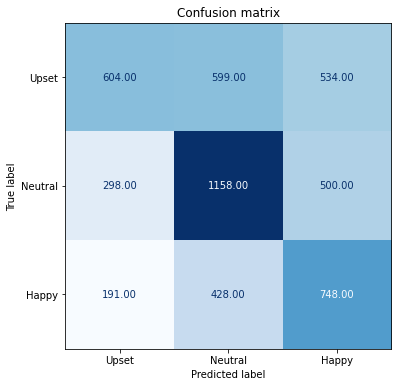

In [ ]:
# CONFUSION MATRIX FOR VALIDATION DATA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Confusion matrix")
  plt.show()

plot_confusion_matrix(test_pred, test_true,labels=label_names)

# Using Prepared Word Representations
In this section, we use GloVe embeddings.

In [ ]:
!mkdir glove
!wget -c https://nlp.stanford.edu/data/glove.6B.zip
!unzip -o -q glove.6B.zip -d glove

--2023-02-10 20:36:01--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-10 20:36:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-02-10 20:38:42 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
X = dataframe['sentence']
y = dataframe['sentiment']
y = to_categorical(y)
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

In [ ]:
vocab_size = 7000
oov_token = "<OOV>"
max_length = 50
padding_type = "post"
trunction_type="post"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train_sequences[10:15]

[[29, 28],
 [4344, 195, 2, 47, 885, 84, 602, 1553],
 [19, 4345, 4, 4346, 10, 2236],
 [70, 2, 415, 67, 977],
 [2, 311, 82, 2929, 5, 2237, 6, 4347, 211]]

In [ ]:
X_train_padded = pad_sequences(X_train_sequences,
                              maxlen=max_length,
                              padding=padding_type, 
                              truncating=trunction_type)

In [ ]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,
                              maxlen=max_length, 
                              padding=padding_type,
                              truncating=trunction_type)

In [ ]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [ ]:
embedding_dim = 32
input_length = 100
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim,)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

Epoch 1/5
506/506 [==============================] - 23s 27ms/step - loss: 1.0912 - accuracy: 0.3824 - val_loss: 1.0888 - val_accuracy: 0.3953
Epoch 2/5
506/506 [==============================] - 7s 14ms/step - loss: 1.0881 - accuracy: 0.3858 - val_loss: 1.0888 - val_accuracy: 0.3953
Epoch 3/5
506/506 [==============================] - 8s 15ms/step - loss: 1.0880 - accuracy: 0.3849 - val_loss: 1.0892 - val_accuracy: 0.3943
Epoch 4/5
506/506 [==============================] - 8s 15ms/step - loss: 1.0875 - accuracy: 0.3863 - val_loss: 1.0895 - val_accuracy: 0.3933
Epoch 5/5
506/506 [==============================] - 7s 14ms/step - loss: 1.0868 - accuracy: 0.3883 - val_loss: 1.0893 - val_accuracy: 0.3950


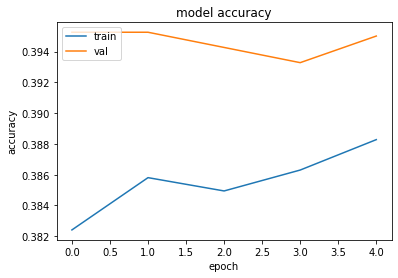

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
y_pred[10]

127/127 [==============================] - 1s 10ms/step


1

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
# REPORT ACCURACY AND F1-SCORE FOR VALIDATION DATA
from sklearn.metrics import classification_report
label_names = ['Upset', 'Neutral', 'Happy']
print('Classifiation report for test set')
print(classification_report(y_test, y_pred,target_names=label_names))

Classifiation report for test set
              precision    recall  f1-score   support

       Upset       0.35      0.01      0.02      1319
     Neutral       0.40      0.99      0.57      1601
       Happy       0.00      0.00      0.00      1128

    accuracy                           0.40      4048
   macro avg       0.25      0.33      0.19      4048
weighted avg       0.27      0.40      0.23      4048



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


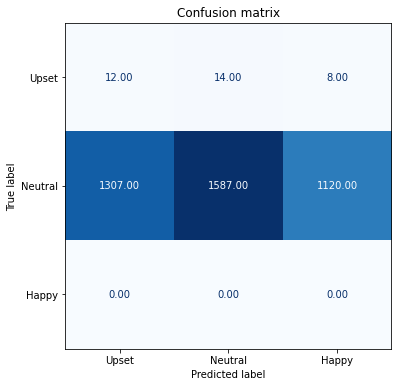

In [ ]:
# CONFUSION MATRIX FOR VALIDATION DATA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Confusion matrix")
  plt.show()

plot_confusion_matrix(y_test, y_pred, labels=label_names)

# Pre-trained Model (BERT)


In [12]:
!pip install transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.5 MB/s eta 0:00:00


## Training

In [13]:
np.random.seed(42)
df_train, df_val, df_test = np.split(dataframe.sample(frac=1, random_state=42), 
                                     [int(.8*len(dataframe)), int(.9*len(dataframe))])

print(len(df_train),len(df_val), len(df_test))

16192 2024 2024


In [ ]:
# NOTE: RUN THIS CELL TO TRAIN AND EVALUATE ON ONLY A FRACTION OF THE DATASET
df_train = df_train.groupby('sentiment').apply(lambda x: x.sample(1000)).reset_index(drop=True)
df_val = df_val.groupby('sentiment').apply(lambda x: x.sample(200)).reset_index(drop=True)
df_test = df_test.groupby('sentiment').apply(lambda x: x.sample(200)).reset_index(drop=True)

In [ ]:
df_train.head(10)

,sentence,sentiment
0,I'm a gamer.,0
1,But it's affecting everybody in the house.,0
2,I'll see you after lunch.,0
3,My name is Alexander Elliot.,0
4,"Oh, dear. The first to break a rule.",0
5,That's going to attract attention.,0
6,"Okay, Bob, whatever. Show us what you got.",0
7,"Not a whole lot, but they park anywhere they w...",0
8,Tt was,0
9,"No, I hadn't heard that.",0


In [15]:
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [16]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(df_train['sentence'].values.tolist())
valid_input_ids, valid_att_masks = encode(df_val['sentence'].values.tolist())
test_input_ids, test_att_masks = encode(df_test['sentence'].values.tolist())

In [ ]:
train_y = torch.LongTensor(df_train['sentiment'].values.tolist())
valid_y = torch.LongTensor(df_val['sentiment'].values.tolist())
test_y = torch.LongTensor(df_test['sentiment'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([3000]), torch.Size([600]), torch.Size([600]))

In [ ]:
BATCH_SIZE = 64
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [17]:
N_labels = len(df_train.sentiment.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

EPOCHS = 10
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*EPOCHS )

In [ ]:
# TRAINING
train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print(f"{step_num+1}/{math.ceil(len(df_train) / BATCH_SIZE)} train loss: {train_loss / (step_num + 1):2.4f}")
    print(f"{step_num_e+1}/{math.ceil(len(df_val) / BATCH_SIZE)} validation loss: {valid_loss / (step_num_e + 1):2.4f}")
    # print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(df_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    # print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(df_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 1.040931540515583 
32/32 val loss: 0.9570441748946905 
Epoch:  2


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.922410779790916 
32/32 val loss: 0.8625340443104506 
Epoch:  3


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.8523737088493679 
32/32 val loss: 0.8300964552909136 
Epoch:  4


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.825500217115455 
32/32 val loss: 0.8208705559372902 
Epoch:  5


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.8056034372729275 
32/32 val loss: 0.8161364458501339 
Epoch:  6


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.7934728571077581 
32/32 val loss: 0.8147549498826265 
Epoch:  7


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.7845724503042198 
32/32 val loss: 0.8182500693947077 
Epoch:  8


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.7775954761995157 
32/32 val loss: 0.8156638629734516 
Epoch:  9


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.7715383523066525 
32/32 val loss: 0.813497994095087 
Epoch:  10


Training:   0%|          | 0/253 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

253/253 train loss: 0.7720200127292528 
32/32 val loss: 0.814174760133028 


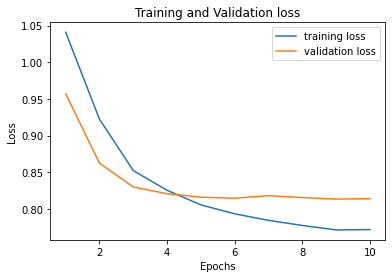

In [ ]:
# PLOT LOSS OVER EPOCH
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
# REPORT ACCURACY AND F1-SCORE FOR VALIDATION DATA
from sklearn.metrics import classification_report
label_names = ['Upset', 'Neutral', 'Happy']
print('Classifiation report for validation set')
print(classification_report(valid_pred, df_val['sentiment'].to_numpy(), target_names=label_names))

Classifiation report for validation set
              precision    recall  f1-score   support

       Upset       0.58      0.65      0.62       639
     Neutral       0.73      0.69      0.71       822
       Happy       0.62      0.58      0.60       563

    accuracy                           0.65      2024
   macro avg       0.64      0.64      0.64      2024
weighted avg       0.65      0.65      0.65      2024



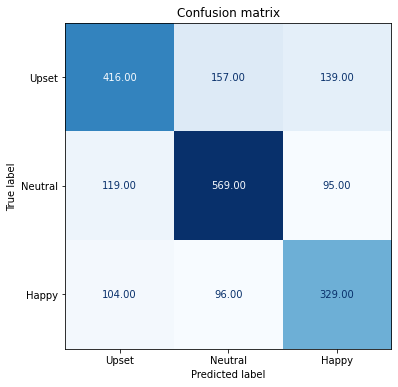

In [ ]:
# CONFUSION MATRIX FOR VALIDATION DATA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Confusion matrix")
  plt.show()

plot_confusion_matrix(valid_pred,df_val['sentiment'].to_numpy(),labels=label_names)

In [ ]:
# TEST MODEL
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('Classifiation report for test set')
print(classification_report(test_pred, df_test['sentiment'].to_numpy(),target_names=label_names))

Classifiation report for test set
              precision    recall  f1-score   support

       Upset       0.54      0.63      0.58       611
     Neutral       0.74      0.65      0.69       851
       Happy       0.63      0.61      0.62       562

    accuracy                           0.64      2024
   macro avg       0.63      0.63      0.63      2024
weighted avg       0.65      0.64      0.64      2024



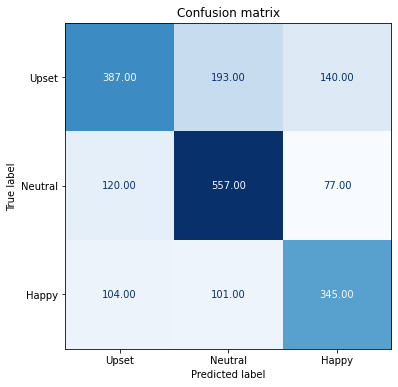

In [ ]:
plot_confusion_matrix(test_pred, df_test['sentiment'].to_numpy(),labels=label_names)

In [ ]:
PATH = project_root + f"/Phase2/BERT_final_model.pkl"
torch.save(
    model.state_dict(), PATH
)

## Evaluation

In [19]:
PATH = project_root + f"/Phase2/BERT_final_model.pkl"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
model.eval()
dataframe_test = pd.DataFrame(columns=['sentence', 'sentiment'])
sentences, sentiments = [], []
for (sentence, sentiment) in dataset['test']:
  sentences.append(sentence)
  sentiments.append(sentiment)
dataframe_test['sentence'] = sentences
dataframe_test['sentiment'] = sentiments
dataframe_test.tail(10)

,sentence,sentiment
5057,Ashlin just posted a pic of a mini-pizza.,0
5058,Second place. $250.,2
5059,"And next Halloween, you can wear that",2
5060,"Okay, so the plan is, we go in there",1
5061,I'll do the talking.,2
5062,"Han, you stand there and try to look smart.",2
5063,"Ah. I'm already Asian. So, done.",2
5064,"Wow, this brings me back.",0
5065,"I had a seat at the popular table,",0
5066,and the Waiting For Marriage table.,0


In [21]:
test_input_ids, test_att_masks = encode(dataframe_test['sentence'].values.tolist())
test_y = torch.LongTensor(dataframe_test['sentiment'].values.tolist())
test_y.size()

torch.Size([5067])

In [22]:
BATCH_SIZE = 64
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [23]:
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [24]:
from sklearn.metrics import classification_report
label_names = ['Upset', 'Neutral', 'Happy']
print('Classifiation report for test set')
print(classification_report(test_pred, dataframe_test['sentiment'].to_numpy(),target_names=label_names))

Classifiation report for test set
              precision    recall  f1-score   support

       Upset       0.55      0.48      0.51      1483
     Neutral       0.71      0.70      0.70      2175
       Happy       0.58      0.66      0.61      1409

    accuracy                           0.62      5067
   macro avg       0.61      0.61      0.61      5067
weighted avg       0.62      0.62      0.62      5067



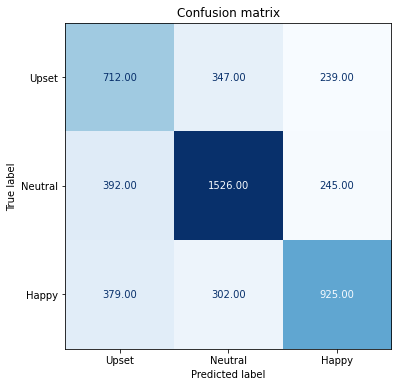

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Confusion matrix")
  plt.show()
  
plot_confusion_matrix(test_pred, dataframe_test['sentiment'].to_numpy(),labels=label_names)

# Evaluation & Comparison

| Represtation/Model| Accuracy  | F1-score  |
| ---               |    ----   |        ---|
| TF-IDF            | %48       | %53       |
| Word2Vec*         | %50       | %56       |
| GloVe             | %40       | %57       |
| BERT              | %62       | %70       |